# Introduction to Lightkurve

Lightkurve is an open source python tool for investigating Kepler, K2, and TESS data.  The available functionality includes:

1. Searching for Kepler, K2 and TESS data at MAST.stsci.edu
2. Downloading target pixel files and lightcurve files from MAST.stsci.edu
3. Investigating and definining custom apertures
4. Creating a bespoke lightcurve
5. Correcting lightcurves
6. Removing systematics from lightcurves
7. Exporting your lightcurves to other formats

And lots more...  I'll touch on these topics (at warp speed).  Oliver Hall will present astereoseismology with lightkurve in the next talk.

You can learn more and find loads more tutorials at https://keplerscience.arc.nasa.gov/software.html and https://docs.lightkurve.org/


In [1]:
import lightkurve as lk

## 1. Searching for data

Lightkurve provides several search functions which allow you to query MAST.stsci.edu for target pixel files, lightcurves and TESS cut-outs.  Targets can be specified by KIC id, EPIC id, TIC id, target name, or RA/Dec.

Target pixel files are a time series of images containing a cut out of pixels around the target.  Let's start by seeing what target pixel files are avaialble...

In [2]:
mytarget = "TIC 301098674"

tpf_list = lk.search_targetpixelfile(mytarget)

tpf_list

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 12,2019,SPOC,120,301098674,0.0
1,TESS Sector 39,2021,SPOC,120,301098674,0.0


Great!  It's got TESS Sector 12 data.  But let's go ahead and look for 30 minute data via the TESS cut service.

In [3]:
tesscut_list = lk.search_tesscut(mytarget)
tesscut_list

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 12,2019,TESScut,1426,TIC 301098674,0.0
1,TESS Sector 39,2021,TESScut,475,TIC 301098674,0.0


And finally -- let's look to see what lightcurves are available...

In [5]:
lc_list = lk.search_lightcurve(mytarget)

lc_list

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 12,2019,SPOC,120,301098674,0.0
1,TESS Sector 12,2019,QLP,1800,301098674,0.0
2,TESS Sector 39,2021,SPOC,120,301098674,0.0


## 2. Downloading data

Now that we know what data's available, let's download a target pixel file and load it into lightkurve. Downloading is a method that applies to lightkurve search results.  

In [6]:
tess_tpf = tpf_list[0].download()

It's also possible to string together the searching and downloading steps into a single command.  The command below yields identical results!

`tess_tpf = lk.search_targetpixelfile(mytarget, mission="K2").download()`

Before moving on, let's investigate this target pixel file object a bit...

What does it look like?

<AxesSubplot:title={'center':'Target ID: 301098674, Cadence: 286200'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

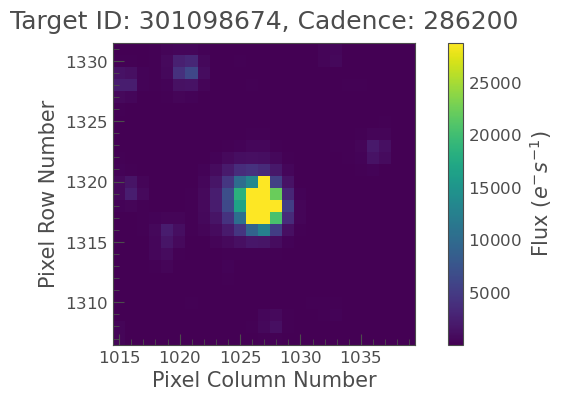

In [7]:
%matplotlib inline 
tess_tpf.plot()

/Users/krp24/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


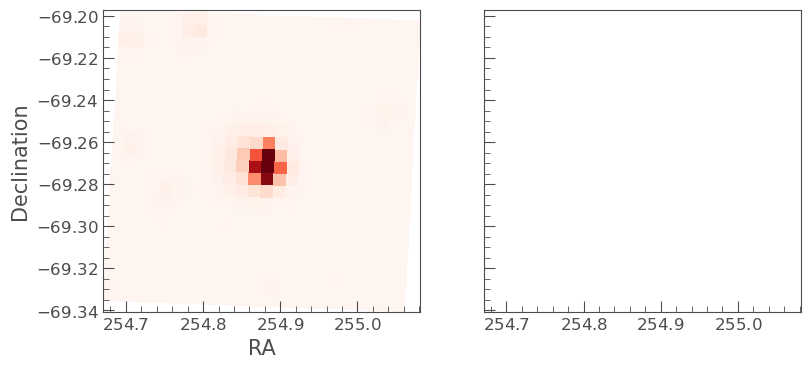

In [8]:
import matplotlib.pyplot as plt
with plt.style.context(lk.MPLSTYLE):
    _, ax = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
    ax[0].pcolormesh(*tess_tpf.get_coordinates(0), tess_tpf.flux[0], cmap='Reds')

    ax[0].set_xlabel("RA")
    ax[0].set_ylabel("Declination")

How big are the images?

In [9]:
tess_tpf.flux.shape

(19104, 25, 25)

Which make sense...  The TESS data is 2 minute cadence for 27 days.


What do the timestamps look like?  

In [10]:
tess_tpf.time

<Time object: scale='tdb' format='btjd' value=[1624.9590638  1624.96045272 1624.96184164 ... 1652.89269933 1652.89408821
 1652.89547709]>

The Kepler/K2 time stamps are Kepler-specific Barycentric Kepler Julian Day format (BKJD).  You can convert it into an astropy time object (http://docs.astropy.org/en/stable/time/) 
WHAT ARE THE TESS TIMESTAMPS? CAN WE DO THE SAME WITH TESS TIMESTAMPS?

In [12]:
tess_tpf.time

<Time object: scale='tdb' format='btjd' value=[1624.9590638  1624.96045272 1624.96184164 ... 1652.89269933 1652.89408821
 1652.89547709]>

Let's take a quick look and see if there are any nearby stars we need to worry about...

*Unfortunately, this won't work in Google Colab because it depends on bokeh*

In [13]:
tess_tpf.interact_sky()

??? This didn't work, but didn't give an error

So, there are some other fainter stars in the neighborhood, but they shouldn't cause a problem.

(The TESS aperture covers a much bigger section of the sky than Kepler) 

## 3. Investigating and Defining Custom Apertures

Overall, the Kepler, K2, and TESS pipelines do an excellent job choosing a aperture mask.  But often a bespoke aperture can be better for a specific source.  Let's start out by looking at the pipeline aperture...


Lightkurve provides 3 ways to define a custom mask:
* a manually defined boolean array 
* a threshold mask 
* interactively

The mask made by create_threshold_mask consists of pixels whose median flux is 3x larger than the standard deviation of the overall median.  The default ratio is 3, but you can specify other threshold ratios if you like.

Let's look at the TESS pipeline aperture and try a couple of alternative apertures.


<AxesSubplot:title={'center':'Target ID: 301098674, Cadence: 286200'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

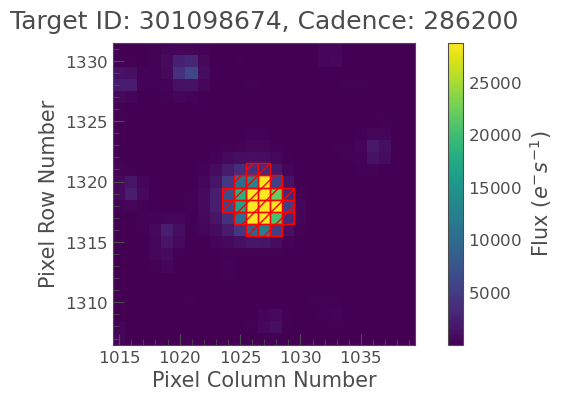

In [14]:
tess_tpf.plot(aperture_mask=tess_tpf.pipeline_mask)

<AxesSubplot:title={'center':'Target ID: 301098674, Cadence: 286200'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

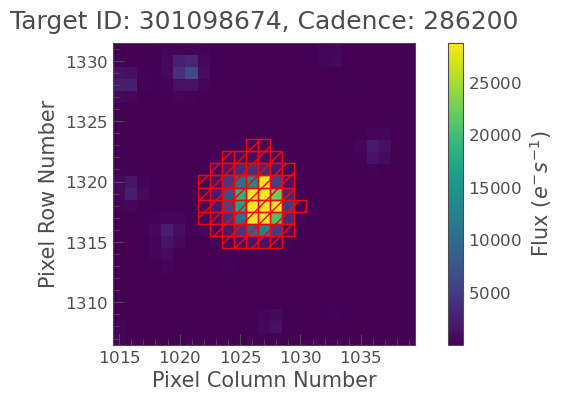

In [15]:
tess_threshold_mask = tess_tpf.create_threshold_mask(threshold=5)

tess_tpf.plot(aperture_mask = tess_threshold_mask)

In [16]:
tess_tpf.interact()

Again, we can read the custom lightcurve back in for future use...

In [18]:
# this cell will read in a locally stored file, but won't work in google colab
tess_interact_lcf = lk.read("tess2019140104343-s0012-0000000301098674-0144-s_tp-custom-lc.fits")

/Users/krp24/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: LightkurveDeprecationWarning: The hdu function is deprecated and may be removed in a future version.
        Use fits.open(lc.filename) instead.
  """Entry point for launching an IPython kernel.


<AxesSubplot:title={'center':'Target ID: 301098674, Cadence: 286200'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

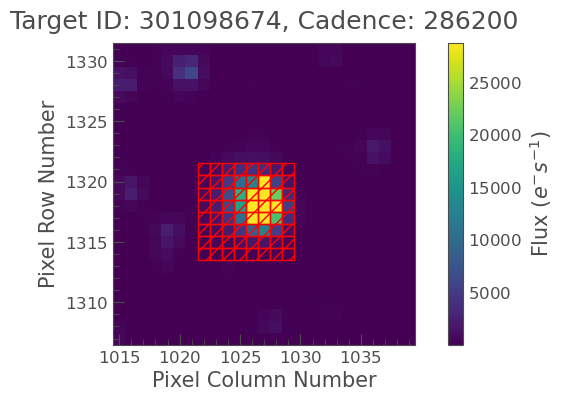

In [21]:
tess_custom_mask = tess_interact_lcf.hdu['APERTURE'].data > 1
tess_tpf.plot(aperture_mask=tess_custom_mask)

## 4. Creating a Lightcurve

Lightkurve can generate a lightcurve from a target pixel file via aperture photometry or prf photometry.   Today, we're going to stick with aperture photometry.  (More info about using lightkurve for prf photometry is available at https://docs.lightkurve.org/.)

Let's do one last check before moving onto creating a lightcurve though -- let's check that there's nothing funky going on in the default background...

TESS background has some heavy lifting to do, so let's check those out also.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

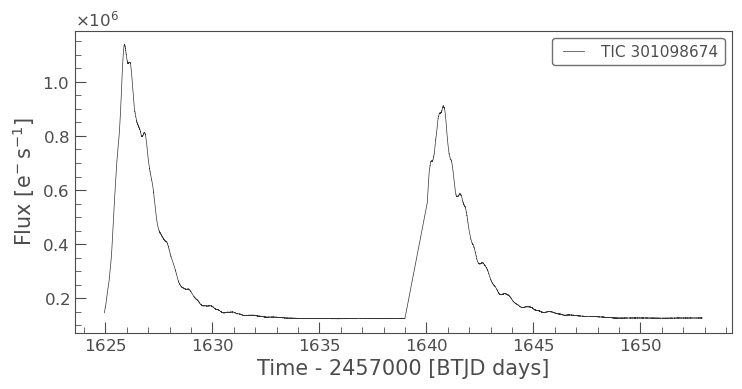

In [22]:
temp = tess_tpf.get_bkg_lightcurve()
temp.plot()


After section #3, we have several different apertures we can try out...  So let's try them all and compare!

Let's take a look at TESS lightcurves using different apertures...

Again, starting with the pipeline mask


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

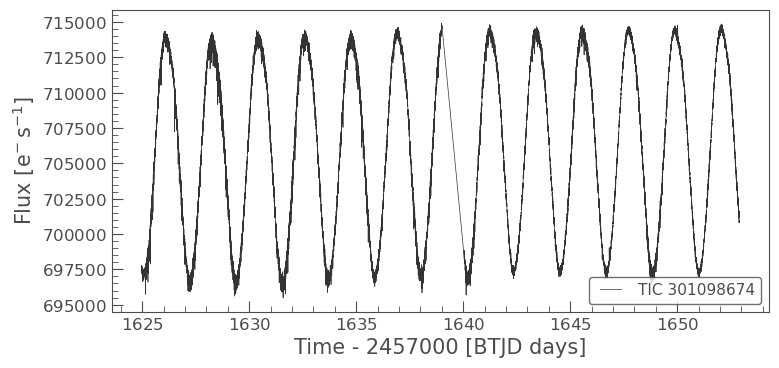

In [23]:
tess_lc = tess_tpf.to_lightcurve()

tess_lc.plot()

And now the threshold mask...

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

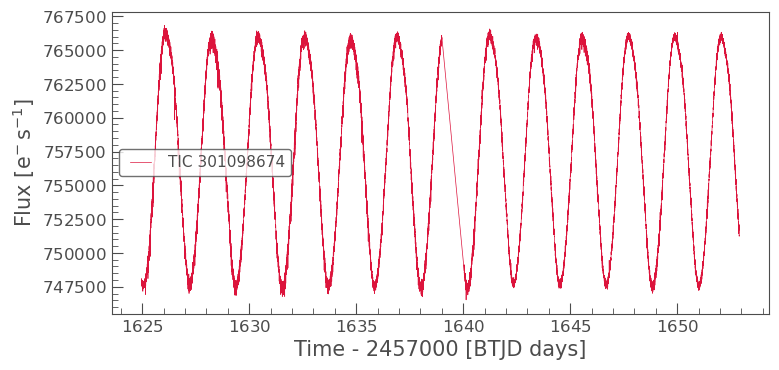

In [24]:
tess_threshold_lc = tess_tpf.to_lightcurve(aperture_mask=tess_threshold_mask)

tess_threshold_lc.plot(color="crimson")

And the custom mask too!

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

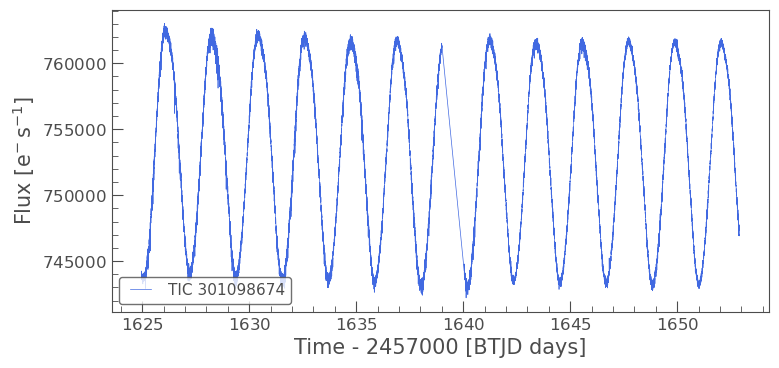

In [25]:
tess_custom_lc = tess_tpf.to_lightcurve(aperture_mask = tess_custom_mask)

tess_custom_lc.plot(color="royalblue")

Comparing the three different TESS lightcurves.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

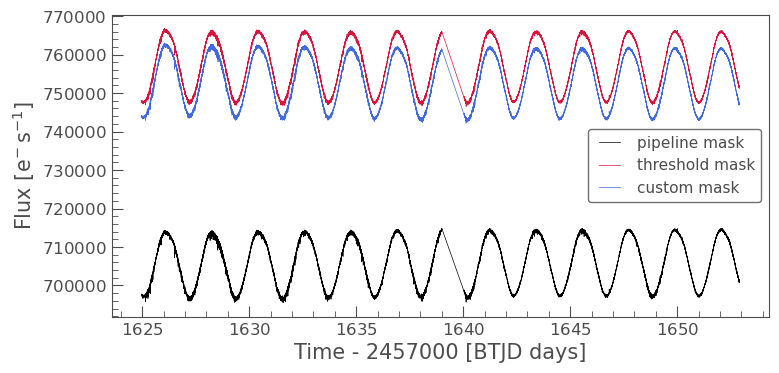

In [26]:
ax = tess_lc.plot(color="k",linestyle="-",label='pipeline mask')  #black
ax = tess_threshold_lc.plot(ax=ax,color="crimson",linestyle='-',label='threshold mask')  #blue
tess_custom_lc.plot(ax=ax,color="royalblue",linestyle="-",label='custom mask')  #red

## 5. Correcting lightcurves

Lightkurve makes it easy to do simple corrections to your lightcurve.  

* `lc.remove_nans()`
* `lc.remove_outliers()`
* `lc.normalize()`
* `lc.flatten()`
* `lc.bin()`

Applying any of these corrections to a lightcurve is trivial.  In the interst of time, I'm not going to step through all of them... 

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

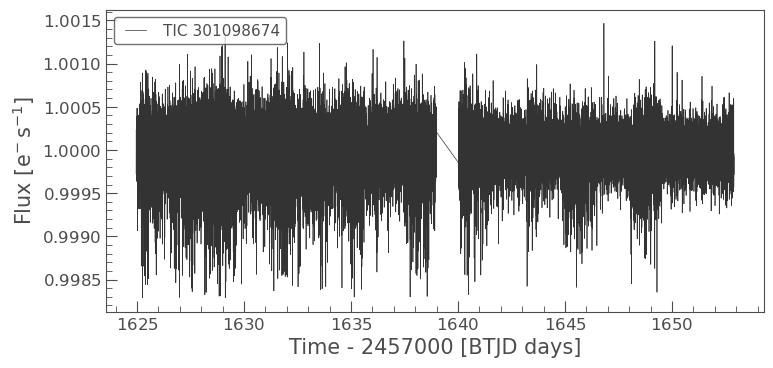

In [27]:
tess_lc = tess_lc.flatten().remove_nans().remove_outliers()
tess_lc.plot()

## 6. Removing systematics

There are several available approaches for removing systematics.  The pipeline lightcurve files include photometry corrected by the Presearch Data Conditioning algorithm. The TESS pipeline also provides detrended lightcurves.  

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

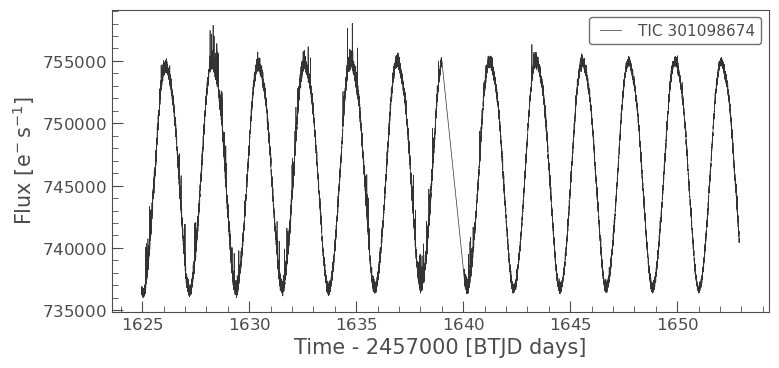

In [31]:
tess_pipeline_lcf = lk.search_lightcurve(mytarget, mission='TESS', author='SPOC', sector=12).download()

tess_pipeline_lcf.plot()

Lightkurve provides 3 ways to perform your own systematics correction.  
* cotrending basis vector correction (CBV)
* self-flat fielding (SFF)
* pixel level decorrelation (PLD)

The cotrending basis vector correction via KeplerCBVCorrector utilizes a method similar to -- but not identical to the pipeline's PDC. It allows you to choose which of the pipeline determined CBVs you want to apply -- and lets you apply the CBV correction to a lightcurve with a mask you define. (A good place to learn more about CBV's is Demystifying Kepler Data at https://arxiv.org/pdf/1207.3093.pdf).

NOT SURE ABOUT TESS SYSTEMATICS...

Let's also have a go at a self-flat fielding correction.  The lightkurve implementation of SFF is heavily based on Vanderburg & Jonson 2014 (https://arxiv.org/pdf/1408.3853.pdf).  There are several tuning parameters for the lightkurve sff correction.  

We can apply SFF to any lightcurve.  The pipeline's PDC is excellent at removing trends that are present across a detector while SFF is designed to remove trends due to the variations in intra- and inter- pixel sensitivity as your source moves.  These two can work well together...

## 7. Exporting Lightcurves

Lightkurve includes functions for converting lightcurves to other formats (pandas, astropy table) and to write them to disk as either csv or fits files.

First let's convert our (UN)corrected TESS lightcurve to pandas...

In [32]:
panda_lc = tess_pipeline_lcf.to_pandas()


To an astropy table...

In [33]:
table_lc = tess_pipeline_lcf.to_table()

Finally let's write it out in two different formats...

In [37]:
tess_pipeline_lcf.to_fits("my_lightcurve.fits", overwrite="TRUE")

tess_pipeline_lcf.to_csv("my_lightcurve.csv")

## Next Steps

Easy ways to learn more about lightkurve

1.  Oliver Hall's tutorial on astereoseismology with lightkuve (up next!)
2.  Check out Nick Saunder's poster
3.  Visit lightkurve.org
4.  Talk to Christina Hedges, Nicholas Saunders, Oliver Hall, or myself.
5.  Contribute at github.com/KeplerGO/lightkurve
